In [9]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
import shap
np.random.seed(42)
# Autoreload
%load_ext autoreload
%autoreload 2
from mlbias.model import *
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Model Training

In [10]:
train, valid, test = train_model(data='../data/credit_line_increase.csv')

2023-09-04 21:54:17.010 | INFO     | mlbias.model:train_model:43 - Reading in data


2023-09-04 21:54:17.063 | INFO     | mlbias.model:train_model:51 - Modifying data
2023-09-04 21:54:17.133 | INFO     | mlbias.model:train_model:92 - Train/Validation/Test sizes: 19919/5045/5036
2023-09-04 21:54:17.196 | INFO     | mlbias.model:train_model:133 - Training model
2023-09-04 21:54:22.028 | INFO     | mlbias.model:train_model:144 - Model trained


In [11]:
# Define variables for further use
id_col = 'ID'
groups = ['SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE']
target = 'DELINQ_NEXT'
features = [col for col in train.columns if col not in groups + [id_col, target]]

### Threshold Selection
Select the optimal probability cutoff by maximizing the F1 score on validation data.
You can choose any other method as well.

In [12]:
model_metrics = perf_metrics(y_true=valid[target], y_score=valid[f'p_{target}'])
model_metrics.loc[model_metrics['f1'].idxmax()]

cutoff       0.260000
recall       0.610773
precision    0.541602
f1           0.574112
Name: 26, dtype: float64

As we set the cutoff to 0.26 , all predictions above 0.26 are not going to get the credit line increase on offer. All predictions that are 0.26 or below will be accepted.

Text(0.5, 0, 'Score Cutoff')

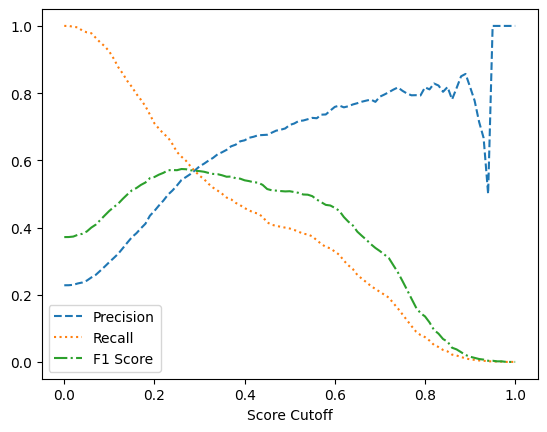

In [13]:
# Since the Disparate Impact Analysis(DIA) analysis will focus on model outcomes
# (rather than scores), choose a cutoff in probability space.

best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
best_cut_original = best_cut

fig, ax = plt.subplots()
ax.plot(model_metrics['cutoff'], model_metrics['precision'], label='Precision',linestyle='--')
ax.plot(model_metrics['cutoff'], model_metrics['recall'], label='Recall',linestyle=':')
ax.plot(model_metrics['cutoff'], model_metrics['f1'], label='F1 Score',linestyle='-.')
ax.legend(loc=3)
ax.set_xlabel('Score Cutoff')